# Explore Device Metadata Available from the State Endpoint

This tutorial walks through the process of exploring and pulling device metadata (e.g., sensing settings, adaptive DBS parameters, stimulation current) from the Rune platform API. Data generated by Medtronic Summit RC+S and Percept devices will be used as examples, but this approach will work with any data available from the State endpoint.

The [State endpoint](https://docs.runelabs.io/#tag/v1state) is more general than data-specific endpoints like [LFP](https://docs.runelabs.io/#tag/v1lfp) or [Accel](https://docs.runelabs.io/#tag/v1accel). It is used with a variety of data that fit the following specifications:

1. Has a numerical value (or can be represented by a numerical value).
2. Its value persists over time, changing at discrete time points ("updates").

(The second specification is not strict, as the State endpoint is occasionally utilized with data that does not technically persist over time, but does not fit any other existing endpoint.)

We utilize the Rune Stream API and Python package `runeq`. Full API documentation can be found here: https://docs.runelabs.io/. Information about the Python package (SDK) can be found here: https://runeq.readthedocs.io/en/latest/.

## Import the necessary packages/modules

We will utilize some commonly used Python packages/modules, including pandas dataframes. Config and stream are imported from the Rune SDK, runeq.

In [1]:
import io
import os
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from runeq import Config, stream

## Functions for pulling "State" data from the API

`get_states` will pull data with the Stream API. These wrapper functions can be easily modified to access the other API endpoints, or to directly write the pulled data to a file.

In [2]:
def make_full_df(accessor):
    """
    Loop through pages of API calls and append to a single dataframe
    Uses the CSV endpoint (which is preferred where available)
    """

    df = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        df = df.append(page_df, ignore_index=True)

    return df


def get_states(client, params, fields, save_filepath=None):
    """Makes API calls for 'state' type data, outputs dataframe"""

    accessor = client.State(**fields, **params)
    df = make_full_df(accessor)

    # Save dataframe to a csv if filepath is specified
    if save_filepath:
        df.to_csv(save_filepath, index=False)

    return df

---

## 1. Initialize API credentials

First initialize your API credentials. These credentials are analogous to having a username/password for accessing patient data. You can set up an access token for read access to all patients within your organization. See our [API doc](https://docs.runelabs.io/stream/#section/Overview/Authentication) for instructions on how to set this up.

Next, set up a .yaml file with your token ID and secret. This is a text file that will store your credentials. See our [`runeq` quickstart](https://runeq.readthedocs.io/en/latest/pages/quickstart.html#configuration) for how to set this up.

Once this .yaml file is in place, it can be used to create a client object.

In [3]:
# Set up a client:

cfg = Config()
client = stream.V1Client(cfg)

If your .yaml file is not in the default location, its path can be passed as an argument to `Config()`.

This client object can now be used to make API calls. Next, we will specify the parameters for our API calls. Check out the full API documentation for required vs. optional parameters per endpoint.

---

## 2. Specify endpoint parameters

The patient ID and device ID can be accessed in the [research portal](https://app.runelabs.io/). The patient ID is at the top left corner of the screen when viewing patient data, and a "copy device ID" button is under each data stream. Both are also available in the patient settings menu (click the "gear" icon).

In this example, two patients are selected: one with a Summit RC+S device, and one with a Percept.

The [Rune research portal](https://app.runelabs.io/) is handy for finding windows of time that include the desired data.

In [4]:
params_summit = {
    'patient_id': '9d8df5a401b84bada7e34a84882c0387',
    'device_id': 'NeOUcqmG',
    'start_time': dt.datetime(2021, 7, 15).timestamp(),
    'end_time': dt.datetime(2021, 7, 16).timestamp(),
    'algorithm': 'medtronic-rcs-3'
}

params_percept = {
    'patient_id': '4cc7953eba444a80aa89983432ae50a2',
    'device_id': 'A4txfzqv',
    'start_time': dt.datetime(2021, 8, 1).timestamp(),
    'end_time': dt.datetime(2021, 9, 1).timestamp()
}

Because data from the State endpoint is typically less dense than other types of data (e.g., LFP, accelerometry), pulling longer time frames of data at once shouldn't take much time, or produce large volumes of data. Here, we will use one day for Summit (with the knowledge that a streaming session was performed on that day), and one month for Percept (to explore unknown data).

The `algorithm` parameter is used for Summit data, to select the latest ingestion algorithm, `medtronic-rcs-3` (which includes timing correction for packet loss, clock drift, etc.) No `algorithm` parameter is currently necessary for Percept data, as Rune has not used multiple algorithms for its ingestion.

---

## 3. Explore State endpoint data

### Nomenclature

The [State endpoint documentation](https://docs.runelabs.io/#tag/v1state) describes the structure of States. In short:

* States are subcategorized by `event_type`. Under each `event_type`, there are different `fields` that represent metadata.
* For example, Summit RC+S data includes an `event_type` labeled `sensing_config.timedomain`, which broadly includes parameters of time domain signals recorded by this device. `fields` under that `event_type` include `channel_0_sampling_frequency_hz`, `channel_0_gain`, etc.

### API usage

In the context of the State endpoint, Rune's Stream API currently supports:

1. Initial exploration of available data:
    1. Discovery of `event_type` and `fields` parameters (described below).
    2. Location of data in time using `availability` expressions (described in other tutorials).
2. Pulling the desired data:
    * Requires as input the chosen `event_type` and one or more `fields` (described in Section 4).
    * Requires as input `start_time` and `end_time` parameters to specify the desired time window.

We will use **Summit RC+S** data for these initial examples, and both **Summit RC+S** and **Percept** data in an additional example later in Section 5.

### Discover the event types that exist in this dataset

Because the default page size for a pull from the State endpoint is 10,000 items, and we don't expect more than 10,000 different event types or unique updates, it is not necessary to handle more than one page of results. Simply create an accessor and pull one page of results using the `event_type` expression:

In [5]:
accessor = client.State(**params_summit)
result = next(accessor.iter_json_data(expression='event_type'))
event_types = result['event_type']

In [6]:
event_types

['adaptive_config',
 'adaptive_update',
 'detection_config',
 'power_config',
 'sampling_frequency.acceleration',
 'sampling_frequency.lfp',
 'sensing_config.fft',
 'sensing_config.power',
 'sensing_config.timedomain',
 'therapy_config.group_0',
 'therapy_config.group_1',
 'therapy_config.group_2',
 'therapy_config.group_3',
 'therapy_status']

Because States typically have values that persist over time, they are separated by group or anatomy/sensor at a higher level. For example, `therapy_config` data is separated into one event type per group (e.g., `therapy_config.group_0`). Each of these event types contains multiple fields.

The `update` expression can be used to explore the fields available for each event type.

### Discover the fields that exist for a chosen event type

Because we are using the `update` expression to explore the available fields, and not to pull the complete data for analysis, we will again only pull the first page of results.

Use the original set of parameters (which include start/end timestamps), and specify the event type of interest as an `event` parameter:

In [7]:
state = client.State(event='adaptive_update', **params_summit)
results = next(state.iter_json_data(expression='update'))

Place the results into a Pandas dataframe for easier viewing, and look at the first ten updates:

In [8]:
pd.DataFrame(results).head(10)

,cardinality,time,update
0,10000,1.626371e+09,"{'adaptive_state': 2, 'ld0_detection_status': ..."
1,10000,1.626371e+09,"{'adaptive_state': 2, 'ld0_detection_status': ..."
2,10000,1.626371e+09,"{'adaptive_state': 1, 'ld0_detection_status': ..."
3,10000,1.626371e+09,"{'adaptive_state': 1, 'ld0_detection_status': ..."
4,10000,1.626371e+09,"{'adaptive_state': 2, 'ld0_detection_status': ..."
5,10000,1.626371e+09,"{'adaptive_state': 2, 'ld0_detection_status': ..."
6,10000,1.626371e+09,"{'adaptive_state': 2, 'ld0_detection_status': ..."
7,10000,1.626371e+09,"{'adaptive_state': 2, 'ld0_detection_status': ..."
8,10000,1.626371e+09,"{'adaptive_state': 2, 'ld0_detection_status': ..."
9,10000,1.626371e+09,"{'adaptive_state': 2, 'ld0_detection_status': ..."


Some event types, such as this one, include several fields. The available fields are clearer from examination of just the keys of the first available update:

In [9]:
for key in results['update'][0].keys():
    print(key)

adaptive_state
ld0_detection_status
ld0_feature_0
ld0_feature_1
ld0_feature_2
ld0_feature_3
ld0_fixed_decimal_point
ld0_output
ld0_threshold_high
ld0_threshold_low
ld1_detection_status
ld1_feature_0
ld1_feature_1
ld1_feature_2
ld1_feature_3
ld1_fixed_decimal_point
ld1_output
ld1_threshold_high
ld1_threshold_low
program_0_amplitude_amp
program_1_amplitude_amp
program_2_amplitude_amp
program_3_amplitude_amp
sensing_status
sensing_status_adaptive_stim
sensing_status_detection_ld_0
sensing_status_detection_ld_1
sensing_status_fft
sensing_status_lfp_sensing
sensing_status_loop_recording
sensing_status_none
sensing_status_power
sensing_status_unused
state_entry_count
state_time
stim_flag_program_0
stim_flag_program_1
stim_flag_program_2
stim_flag_program_3
stim_flags
stim_rate_hz


Once you have explored the available event types and fields, those of interest can be used to pull the desired data from the State endpoint.

---

## 4. Pull the desired State endpoint data

A few examples of Summit data available from the State endpoint are shown below. Each example creates a dictionary of the desired `event` and `fields` parameters, and passes it to the `get_states` function (defined at the beginning of this notebook).

**Note:** If the `start_time` specified is previous to the first available update of a field, the first row of the result will be `NaN`. This indicates that the value at that time is unknown.

### Active group and therapy status

Active group tracks which group of settings is active on the device at any time (0-3 correspond to A-D). Therapy status is represented as an integer representing several options:

0. Off
1. On
2. Lead integrity test
3. Transitioning to off
4. Transitioning to active
5. Transitioning to lead integrity test

In [10]:
# Create a dictionary of the desired event and fields, then pull the data:

active_group_fields = {
    'event': 'therapy_status',
    'fields': 'active_group,'
              'therapy_status'
}

active_group = get_states(client, params_summit, active_group_fields)
active_group.head(10)

,time,active_group,therapy_status
0,1.626329e+09,1,1
1,1.626371e+09,1,1
2,1.626371e+09,1,1
3,1.626371e+09,1,1
4,1.626371e+09,3,1
5,1.626371e+09,3,1
6,1.626371e+09,3,1
7,1.626371e+09,3,1
8,1.626371e+09,3,1
9,1.626371e+09,3,1


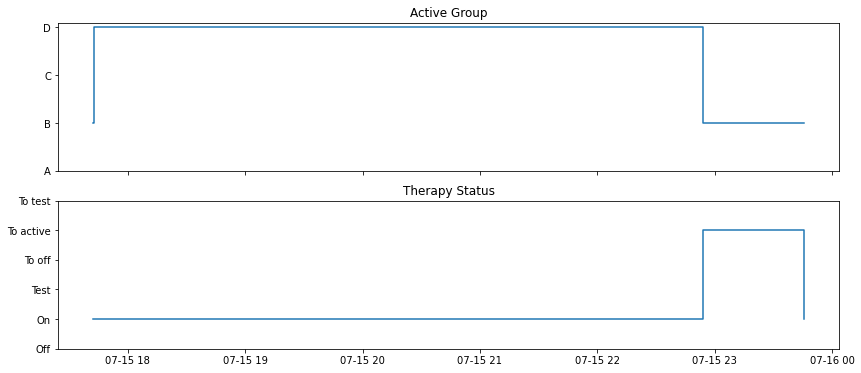

In [11]:
# Plot the active group and therapy status:

# Remove the first and last row, which are the given start/end timestamps.
#  This allows easier viewing of the data in this plot format.
# Convert timestamps to datetime format for readability.

fig, ax = plt.subplots(2, figsize=(14, 6), sharex=True)

ax[0].step(pd.to_datetime(
    active_group.time.iloc[1:-1], unit='s'), active_group.active_group.iloc[1:-1])
ax[0].set_title('Active Group')
ax[0].set_yticks((0, 1, 2, 3))
ax[0].set_yticklabels(('A', 'B', 'C', 'D'))

ax[1].step(pd.to_datetime(active_group.time.iloc[1:-1],
                          unit='s'), active_group.therapy_status.iloc[1:-1])
ax[1].set_title('Therapy Status')
ax[1].set_yticks((0, 1, 2, 3, 4, 5))
ax[1].set_yticklabels(('Off', 'On', 'Test', 'To off', 'To active', 'To test'));

### Adaptive algorithm updates

The status of various parameters of the adaptive DBS algorithms is available for each linear detector. Examine a few for linear detector 0:

In [12]:
adaptive_update_fields = {
    'event': 'adaptive_update',
    'fields': 'ld0_output,'
              'ld0_threshold_high,'
              'ld0_threshold_low'
}

adaptive_updates = get_states(client, params_summit, adaptive_update_fields)
adaptive_updates.head(10)

,time,ld0_output,ld0_threshold_high,ld0_threshold_low
0,1.626329e+09,14,44,12
1,1.626371e+09,50,44,12
2,1.626371e+09,50,44,12
3,1.626371e+09,31,44,12
4,1.626371e+09,31,44,12
5,1.626371e+09,50,44,12
6,1.626371e+09,50,44,12
7,1.626371e+09,70,44,12
8,1.626371e+09,70,44,12
9,1.626371e+09,47,44,12


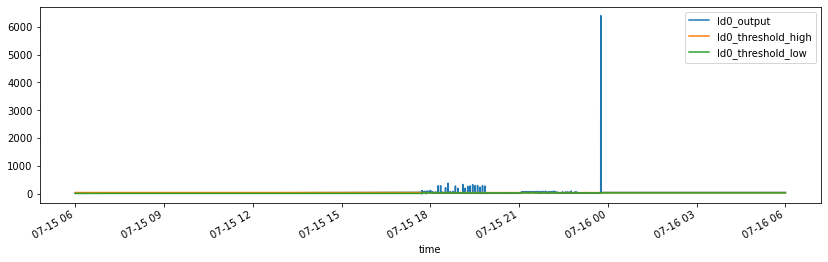

In [13]:
# Plot linear detector 0 updates:

# Use the Pandas plot function, which is a wrapper for matplotlib, for convenience.
# Convert timestamps to datetime format for readability.

adaptive_updates.time = pd.to_datetime(adaptive_updates.time, unit='s')
adaptive_updates.plot(x='time', figsize=(14, 4));

This view of the adaptive data isn't very useful, as it includes the start/end timestamps, and an extreme outlier. For a quick look, slice a segment of the data that doesn't include those samples:

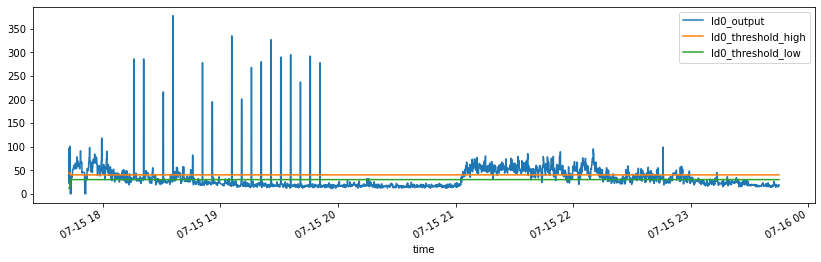

In [14]:
# Slice to remove the first sample, and any after the approximate time of the outlier(s):

adaptive_updates[(adaptive_updates.index > 0) &
                 (adaptive_updates.time < dt.datetime(
                     2021, 7, 15, hour=23, minute=45))
                 ].plot(x='time', figsize=(14, 4));

### Sensing configuration

Various settings describing the sensing configuration for each channel are available, including the gain, high- and low-pass filters, electrode contacts, sampling frequency, etc. Examine a few for channel 0:

In [15]:
sensing_config_fields = {
    'event': 'sensing_config.timedomain',
    'fields': 'channel_0_gain,'
              'channel_0_hpf,'
              'channel_0_lpf1,'
              'channel_0_lpf2,'
              'channel_0_minus_input,'
              'channel_0_plus_input,'
              'channel_0_sampling_frequency_hz'
}

sensing_config = get_states(client, params_summit, sensing_config_fields)
sensing_config.head(10)

,time,channel_0_gain,channel_0_hpf,channel_0_lpf1,channel_0_lpf2,channel_0_minus_input,channel_0_plus_input,channel_0_sampling_frequency_hz
0,1.626329e+09,250,8.5,100,100,1,3,500
1,1.626371e+09,250,8.5,100,100,1,3,500
2,1.626371e+09,250,8.5,100,100,1,3,500
3,1.626371e+09,250,8.5,100,100,1,3,500
4,1.626371e+09,250,8.5,100,100,1,3,500
5,1.626376e+09,250,8.5,100,100,1,3,500
6,1.626415e+09,250,8.5,100,100,1,3,500


The dataframe can be sliced, manipulated, visualized, and stored as desired for your analysis.

---

## 5. Automated exploration

By automating the exploration steps demonstrated in Section 3, one can quickly ascertain which `event` and `field` parameters are available for a given dataset. In this example, we will explore one day of **Summit RC+S** data, and one month of **Percept** data.

### Summit RC+S metadata

In [16]:
accessor = client.State(**params_summit)
result = next(accessor.iter_json_data(expression='event_type'))
event_types = result['event_type']

In [17]:
# Loop through the event types and pull/print all fields for each:

for event_type in event_types:
    print(f'{event_type} fields:')
    state = client.State(event=event_type, **params_summit)
    results = next(state.iter_json_data(expression='update'))
    try:
        for key in results['update'][0].keys():
            print(f'    {key}')
    except IndexError:
        print('    N/A for this time frame')

adaptive_config fields:
    adaptive_mode
    adaptive_status
    channel_0_fall
    channel_0_rise
    channel_1_fall
    channel_1_rise
    channel_2_fall
    channel_2_rise
    channel_3_fall
    channel_3_rise
    current_state
    delta_limits_valid
    deltas_valid
    state0_prog0_amplitude_in_amps
    state0_prog1_amplitude_in_amps
    state0_prog2_amplitude_in_amps
    state0_prog3_amplitude_in_amps
    state0_rate_target_in_hz
    state1_prog0_amplitude_in_amps
    state1_prog1_amplitude_in_amps
    state1_prog2_amplitude_in_amps
    state1_prog3_amplitude_in_amps
    state1_rate_target_in_hz
    state2_prog0_amplitude_in_amps
    state2_prog1_amplitude_in_amps
    state2_prog2_amplitude_in_amps
    state2_prog3_amplitude_in_amps
    state2_rate_target_in_hz
    state3_prog0_amplitude_in_amps
    state3_prog1_amplitude_in_amps
    state3_prog2_amplitude_in_amps
    state3_prog3_amplitude_in_amps
    state3_rate_target_in_hz
    state4_prog0_amplitude_in_amps
    state4_prog1_

    program_0_active_ratio
    program_1_active_ratio
    program_2_active_ratio
    program_3_active_ratio
therapy_config.group_2 fields:
    program_0_active_ratio
    program_1_active_ratio
    program_2_active_ratio
    program_3_active_ratio
therapy_config.group_3 fields:
    program_0_active_ratio
    program_1_active_ratio
    program_2_active_ratio
    program_3_active_ratio
therapy_status fields:
    active_group
    therapy_status


### Percept metadata

In [18]:
accessor = client.State(**params_percept)
result = next(accessor.iter_json_data(expression='event_type'))
event_types = result['event_type']

In [19]:
# Loop through the event types and pull/print all fields for each:

for event_type in event_types:
    print(f'{event_type} fields:')
    state = client.State(event=event_type, **params_percept)
    results = next(state.iter_json_data(expression='update'))
    try:
        for key in results['update'][0].keys():
            print(f'    {key}')
    except IndexError:
        print('    N/A for this time frame')

calibration.left-0-2 fields:
    gain_db
    sample_rate_in_hz
calibration.left-1-3 fields:
    gain_db
    sample_rate_in_hz
calibration.right-0-2 fields:
    gain_db
    sample_rate_in_hz
calibration.right-1-3 fields:
    gain_db
    sample_rate_in_hz
event_logs.active_group fields:
    new_group_id
    old_group_id
event_logs.adbs_enable fields:
    adbs_status
event_logs.therapy_status fields:
    therapy_status
event_summary.group_a.left.stn fields:
    above_threshold_percent
    adaptive_amplitude_reduction_percent
    average_amplitude
    below_threshold_percent
    between_threshold_percent
    time_adaptive_running_percent
event_summary.group_a.right.stn fields:
    above_threshold_percent
    adaptive_amplitude_reduction_percent
    average_amplitude
    below_threshold_percent
    between_threshold_percent
    time_adaptive_running_percent
group_history.group_a fields:
    left-1-3_adaptive_therapy_adaptive_startup_delay_in_milli_seconds
    left-1-3_adaptive_therapy_detec

As noted above, the structure of States necessitates that some be separated by group or anatomy/sensor at a higher level. `group_history` here is a good example of this. `'event': 'group_history.group_a'` includes a variety of fields for the hemisphere/sensor combinations that exist in this time frame: `left-1-3` and `right-1-3`.

Beyond this separation, the naming conventions of these event types and fields map closely to those found in raw Percept JSON data files.

---

## 6. Summary

This notebook serves as a tutorial for exploring and pulling device metadata from the State endpoint of the [Rune API](https://docs.runelabs.io/). The included procedure can be followed to explore any data available from the State endpoint. Once the desired classifications of data (event type and fields) are ascertained, specific data can be pulled from the API and manipulated, visualized, or stored for further use.